In [118]:
import os
import cv2
import h5py
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import albumentations as A
import matplotlib.pyplot as plt


from transform import Resize, NormalizeImage, PrepareForNet, Crop  # giữ nguyên như code Depth-Anything-V2

def get_all_files(directory, rgb_prefix="rgb_image_", depth_prefix="depth_map_"):
    """
    Tạo list chứa tuple (rgb_path, depth_path).
    Dùng khi ảnh RGB và depth được lưu thành file .jpg/.png riêng.
    """
    rgb_files = sorted([f for f in os.listdir(directory + "/images") if f.endswith(".jpg")])
    depth_files = sorted([f for f in os.listdir(directory + "/labels") if f.endswith(".png")])

    all_paths = []
    for rgb, depth in zip(rgb_files, depth_files):
        rgb_path = os.path.join(directory, "images", rgb)
        depth_path = os.path.join(directory, "labels", depth)
        all_paths.append((rgb_path, depth_path))
    return all_paths


class NYUDataset(Dataset):
    def __init__(self, paths, mode="train", size=(224, 224)):
        """
        paths: list các tuple (rgb_path, depth_path)
        mode : "train" hoặc "val"
        size : kích thước resize cuối
        """
        self.paths = paths
        self.mode = mode
        self.size = size

        net_w, net_h = size
        # Transform giống Depth-Anything
        self.transform = Compose([
            Resize(
                width=net_w,
                height=net_h,
                resize_target=True,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method="lower_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ] + ([Crop(size[0])] if mode == "train" else []))

        # Augmentation riêng cho train
        self.augs = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(hue=0.1, contrast=0.1, brightness=0.1, saturation=0.1, p=0.5),
            A.GaussNoise(
            std_range=[0.03, 0.07],
            mean_range=[0, 0.2],
            per_channel=True,
            noise_scale_factor=1,
            p = 0.3
        )
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        rgb_path, depth_path = self.paths[index]

        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # BGR -> RGB
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

        if self.mode == "train":
            augmented = self.augs(image=rgb, mask=depth)
            rgb = augmented["image"] / 255.0
            depth = augmented["mask"]
        else:
            rgb = rgb / 255.0

        sample = self.transform({"image": rgb, "depth": depth})
        sample["image"] = torch.from_numpy(sample["image"])
        sample["depth"] = torch.from_numpy(sample["depth"])

        return sample


def get_dataloaders(batch_size):
    train_paths = get_all_files("dataset_ours/train")
    val_paths = get_all_files("dataset_ours/val")

    train_dataset = NYUDataset(train_paths, mode="train", size=(224, 224))
    val_dataset = NYUDataset(val_paths, mode="val", size=(224, 224))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=4, pin_memory=True, drop_last=True)

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                            num_workers=2, pin_memory=True, drop_last=False)

    return train_loader, val_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005917384982109086..1.0658047494888305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012443298339843756..1.0713163692951202].


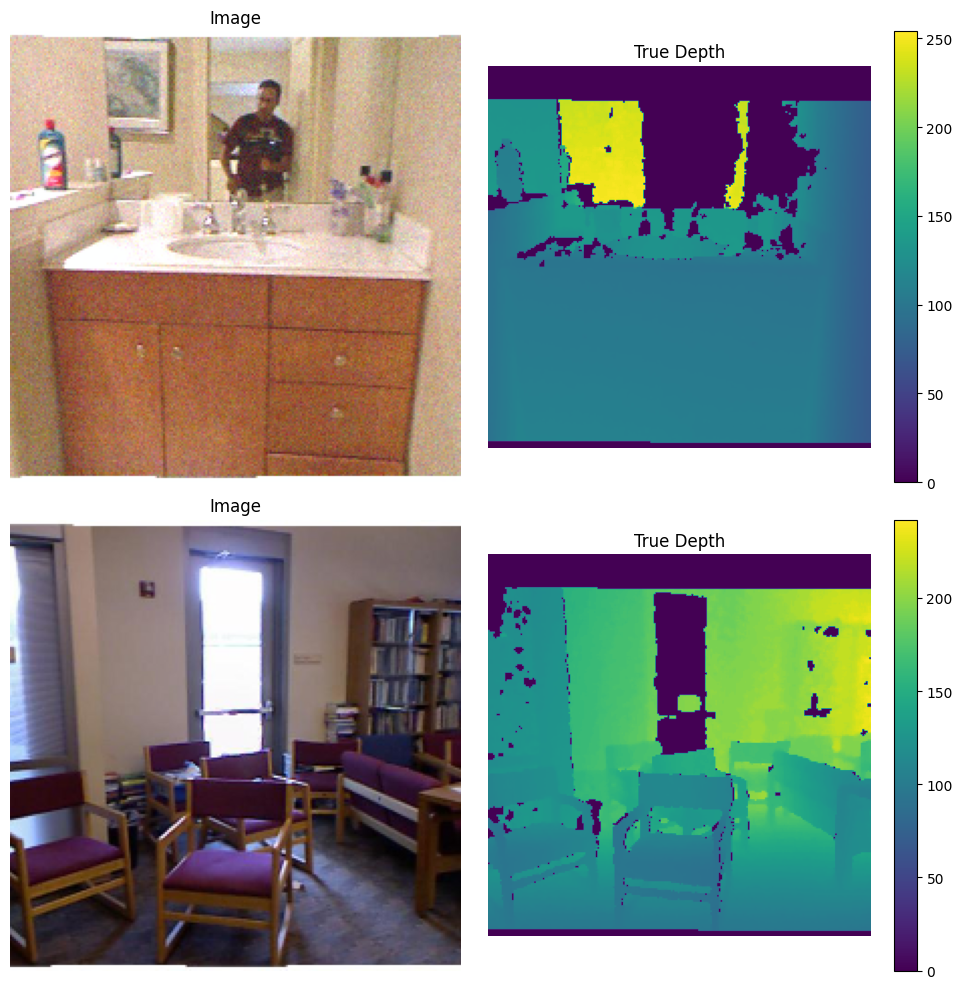

In [119]:
num_images = 2

fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

val_paths = get_all_files("dataset_ours/val")
train_set = NYUDataset(val_paths, mode="train", size=(224, 224))

for i in range(num_images):
    idx = random.randint(0, len(train_set) - 1)  # chọn index ngẫu nhiên
    # print(f"i index: {i}")
    sample = train_set[idx]
    img, depth = sample['image'].numpy(), sample['depth'].numpy()

    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img = img*std+mean

    axes[i, 0].imshow(np.transpose(img, (1,2,0)))
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    im1 = axes[i, 1].imshow(depth, cmap='viridis', vmin=0)
    axes[i, 1].set_title('True Depth')
    axes[i, 1].axis('off')
    fig.colorbar(im1, ax=axes[i, 1])
    

plt.tight_layout()

In [1]:
from models import FastDepthV2, FastDepth, weights_init
import dataloader
from load_pretrained import load_pretrained_encoder, load_pretrained_fastdepth

In [2]:
model = FastDepthV2()
model.encoder = load_pretrained_encoder(model.encoder,'Weights','mobilenetv2')
model.decoder.apply(weights_init)

NNConv5_DecoderV2(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(320, 320, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=320, bias=False)
      (1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(320, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Sequential(
      (0): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=96, bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [3]:
model

FastDepthV2(
  (encoder): MobileNetV2_Encoder(
    (enc_layer0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (enc_layer1): InvertedResidualBlock(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (enc_layer2): InvertedResidualBlock(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [4]:
import torch

# Giả sử model nhận input shape (batch, channels, height, width)
batch_size = 8
channels = 3
height = 480
width = 640

x = torch.randn(batch_size, channels, height, width)  # random input


In [5]:
out = model(x)

In [6]:
out

tensor([[[[2.5394e-01, 2.5394e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5394e-01, 2.5394e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.8852e-02, 5.8852e-02, 9.0224e-02,  ..., 9.2657e-01,
           4.7797e-01, 4.7797e-01],
          ...,
          [1.7507e-01, 1.7507e-01, 0.0000e+00,  ..., 1.3224e+00,
           2.4006e-01, 2.4006e-01],
          [0.0000e+00, 0.0000e+00, 2.0566e-01,  ..., 1.1778e+00,
           1.2613e-01, 1.2613e-01],
          [0.0000e+00, 0.0000e+00, 2.0566e-01,  ..., 1.1778e+00,
           1.2613e-01, 1.2613e-01]]],


        [[[6.8755e-02, 6.8755e-02, 1.0340e+00,  ..., 8.3520e-01,
           1.5688e-01, 1.5688e-01],
          [6.8755e-02, 6.8755e-02, 1.0340e+00,  ..., 8.3520e-01,
           1.5688e-01, 1.5688e-01],
          [8.7314e-01, 8.7314e-01, 3.6267e-01,  ..., 0.0000e+00,
           6.7828e-01, 6.7828e-01],
          ...,
          [0.0000e+00, 0.0000e+00, 4.8428e-02,  ..., 1.12

In [7]:
out.size()

torch.Size([8, 1, 480, 640])

In [8]:
train_loader, val_loader = dataloader.get_combined_dataloaders(batch_size)

In [9]:
from tqdm import tqdm
device = "cpu"
model = model.eval()

In [10]:

def eval_depth(pred, target):
    assert pred.shape == target.shape

    thresh = torch.max((target / pred), (pred / target))

    d1 = torch.sum(thresh < 1.25).float() / len(thresh)

    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    abs_rel = torch.mean(torch.abs(diff) / target)

    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    mae = torch.mean(torch.abs(diff))

    silog = torch.sqrt(torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2))

    return {'d1': d1.detach(), 'abs_rel': abs_rel.detach(),'rmse': rmse.detach(), 'mae': mae.detach(), 'silog':silog.detach()}

In [11]:
import torch.nn.functional as F

In [20]:
results = {'d1': 0, 'abs_rel': 0, 'rmse': 0, 'mae': 0, 'silog': 0}
with torch.no_grad():
    for sample in tqdm(val_loader):
        img, depth = sample['image'].to(device), sample['depth'][0].to(device)

        # print(f"depth: {depth.size()}")

        pred = model(img)

        # print(f"pred: {pred.size()}")

        # pred = F.interpolate(pred[:, None], depth.shape[-2:], mode='bilinear', align_corners=True)[0, 0]
        # Resize về cùng size với depth
        pred = F.interpolate(pred, size=depth.shape[-2:], mode='bilinear', align_corners=True)

        # print(f"pred 2: {pred.size()}")

        # Bỏ channel dimension
        pred = pred.squeeze(1).squeeze(0)  # [N, H, W]

        # print(f"pred 3: {pred.size()}")


        mask = (depth >= 0.001)
        cur_results = eval_depth(pred[mask], depth[mask])

        for k in results:
            results[k] += cur_results[k]


100%|██████████| 850/850 [02:43<00:00,  5.21it/s]


In [1]:
import cv2
import numpy as np
import os
from dataloader import get_all_files_nyu, get_all_files_rgbd

def check_depth_dataset(paths):
    for i, (rgb_path, depth_path) in enumerate(paths):
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            print(f"[ERROR] Không đọc được depth: {depth_path}")
            continue

        depth = depth.astype(np.float32)
        dmin, dmax = depth.min(), depth.max()

        # Kiểm tra giá trị bất thường
        if dmax > -100 or np.isnan(depth).any() or np.isinf(depth).any():
            print(f"[{i}] LỖI depth tại {depth_path} | min={dmin}, max={dmax}")

check_depth_dataset(get_all_files_nyu("dataset_ours/nyudepthv2/train"))
check_depth_dataset(get_all_files_rgbd("dataset_ours/rgbd-scenes-v2/train"))


[0] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0000.png | min=0.0, max=255.0
[1] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0002.png | min=0.0, max=255.0
[2] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0003.png | min=0.0, max=255.0
[3] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0005.png | min=0.0, max=255.0
[4] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0007.png | min=0.0, max=255.0
[5] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0008.png | min=0.0, max=255.0
[6] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0009.png | min=0.0, max=255.0
[7] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0010.png | min=0.0, max=255.0
[8] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0011.png | min=0.0, max=255.0
[9] LỖI depth tại dataset_ours/nyudepthv2/train/labels/depth_map_0012.png | min=0.0, max=255.0
[10] LỖI depth tại dataset_ours/nyudepthv2/train/l

In [10]:
import cv2
import numpy as np
import os

depth_files = os.listdir("dataset_ours/pseudo-labels/content/pseudo-labels")

for file in depth_files:
    img = cv2.imread(f"dataset_ours/pseudo-labels/content/pseudo-labels/{file}", cv2.IMREAD_GRAYSCALE)
    depth = img.astype(np.float32)
    dmin, dmax = depth.min(), depth.max()

    # Kiểm tra giá trị bất thường
    if dmax > -100 or np.isnan(depth).any() or np.isinf(depth).any():
        print(f"LỖI depth tại {file} | min={dmin}, max={dmax}")

LỖI depth tại rgbd-scenes-v2_train_scene_01_00091-color.png | min=0.0, max=255.0
LỖI depth tại nyudepthv2_train_rgb_image_0550.jpg | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_11_00292-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_08_00368-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_12_00308-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_10_00080-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_07_00642-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_13_00228-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_04_00147-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_06_00995-color.png | min=0.0, max=255.0
LỖI depth tại nyudepthv2_train_rgb_image_0736.jpg | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_03_00474-color.png | min=0.0, max=255.0
LỖI depth tại rgbd-scenes-v2_train_scene_01_0029

In [3]:
from datasets import load_dataset

val_ds = load_dataset("benediktkol/DDOS", split="validation", streaming=False)
test_ds = load_dataset("benediktkol/DDOS", split="test", streaming=False)

val_ds.save_to_disk("./DDOS_val")
test_ds.save_to_disk("./DDOS_test")


Using the latest cached version of the dataset since benediktkol/DDOS couldn't be found on the Hugging Face Hub


FileNotFoundError: [Errno 2] No such file or directory: '/home/tamcn/.cache/huggingface/datasets/benediktkol___ddos/default/0.0.0/1ed1314d32ef3a5a7e1434000783a8433517bd0e.incomplete/dataset_info.json'

In [2]:
import os
import shutil

root_dir = "dataset_ours"
output_dir = "unlabel_dataset"
os.makedirs(output_dir, exist_ok=True)

for dataset_name in os.listdir(root_dir):
    dataset_path = os.path.join(root_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    for split in ["train", "val", "test"]:
        split_path = os.path.join(dataset_path, split, "images")
        if not os.path.isdir(split_path):
            continue

        for file_name in os.listdir(split_path):
            src_path = os.path.join(split_path, file_name)

            # thêm prefix dataset_split_ để tránh trùng
            new_name = f"{dataset_name}_{split}_{file_name}"
            dst_path = os.path.join(output_dir, new_name)

            shutil.copy2(src_path, dst_path)

print("Copy xong!")


Copy xong!


In [3]:
import h5py
import numpy as np
from PIL import Image

file_path = "raw_dataset/data_apple/ai_001_001/images/scene_cam_00_final_hdf5/frame.0000.color.hdf5"

# Đọc file HDF5
with h5py.File(file_path, "r") as f:
    key = list(f.keys())[0]  # lấy key đầu tiên
    data = f[key][:]         # (H, W, 3), float16

# Chuyển sang float32 để xử lý
img = data.astype(np.float32)

# Tone mapping (log) để hiển thị đẹp hơn
img_tonemap = np.log1p(img) / np.log1p(img.max())

# Chuyển sang 8-bit
img_8bit = (np.clip(img_tonemap, 0, 1) * 255).astype(np.uint8)

# Lưu thành PNG
Image.fromarray(img_8bit).save("frame_0000_color.png")

print("✅ Đã lưu frame_0000_color.png")


✅ Đã lưu frame_0000_color.png


In [11]:
import os
import shutil
import random

raw_root = "./raw_dataset/data_danything"
pseudo_dir = os.path.join(raw_root, "pseudo-labels")
unlabel_dir = os.path.join(raw_root, "unlabel_dataset")

out_root = "./dataset_ours/danything"
splits = ["train", "val"]

for split in splits:
    os.makedirs(os.path.join(out_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(out_root, split, "labels"), exist_ok=True)

# Lấy danh sách file chung
files = sorted(os.listdir(unlabel_dir))
files = [f for f in files if os.path.isfile(os.path.join(unlabel_dir, f))]

random.seed(0)  # cố định kết quả
random.shuffle(files)

n_train = int(len(files) * 0.9)
train_files = files[:n_train]
val_files = files[n_train:]

def copy_split(file_list, split):
    for f in file_list:
        img_src = os.path.join(unlabel_dir, f)
        label_src = os.path.join(pseudo_dir, f)

        img_dst = os.path.join(out_root, split, "images", f)
        label_dst = os.path.join(out_root, split, "labels", f)

        shutil.copy2(img_src, img_dst)
        shutil.copy2(label_src, label_dst)

copy_split(train_files, "train")
copy_split(val_files, "val")

print(f"Train: {len(train_files)}, Val: {len(val_files)}")


Train: 3815, Val: 424
